### AI Lab -  Assignment 7 - CH22M503

#### Author - Aloy Banerjee
###### Roll No. CH22M503

## Question:
###### A team of researchers has collected image data of human cells 1 to predict the malarial infected cell. The file shared ‘Datasets.zip’ has the required data. Students must work on the folder that is named after their respective roll numbers. Each folder has two subfolders ‘parasite’ and ‘uninfected’ referring to the positive and the negative classes.
###### (a) Build a Convolutional Neural Network model that can predict the input image as uninfected or parasite. Note that the dataset could be highly imbalanced. (Hint: Use weighted sampling (or) weighted loss function (or) augment the dataset to generate more samples of the imbalanced class)
###### (b) Report the prediction accuracy, precision, recall, and F1 score in the test dataset.
###### (c) (Optional) Try finding a similar human cell image classification model and fine-tune the model using the images shared with you and compare its performance with the model trained by you.

#### Reference

#### Importing Library

In [1]:
#Basic Libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#For image operation
import cv2
from PIL import Image

#For Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset

#For SK Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, accuracy_score, make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neural_network import MLPClassifier

from tqdm import tqdm

#### Common variable declaration

In [2]:
workingDir = 'C:\\Users\\Admin\\Coding-M-Tech\\AI Lab - ID5002W\\Assignment 7\\Datasets\\ch22m503\\'
dataset_folderName = ['parasite', 'uninfected']
img_size = 150
seed = 42
dataset = []
label = []
epochs = 100
round_precesion= 2
positive_class = 0
negative_class = 0

In [3]:
os.chdir(workingDir)

#### Common function

In [4]:
def data_load(dataset, label):
    '''Splitting the dataset into train, test and validation'''
    X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
    return X_train, X_val, X_test, y_train, y_val, y_test

def normalize_data(X):
    '''Normalize the dataset'''
    return X.astype('float32') / 255.

def one_hot_encode_labels(Y):
    '''Manual one hot encoding of the target value'''
    return np.eye(10)[Y]

def flatten_array(X):
    '''Perform array flattening operation'''
    return X.reshape((len(X), np.prod(X.shape[1:])))

def data_normalize(X_train, X_validation, X_test, Y_train, Y_validation, Y_test):
    '''Notmalize the input data '''
    # Normalize the input images
    X_train = normalize_data(X_train)
    X_validation = normalize_data(X_validation)
    X_test = normalize_data(X_test)
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

def flatten_data(X_train,X_val,X_test):
    '''Perform array flattening operation'''
    X_train = flatten_array(X_train)
    X_val = flatten_array(X_val)
    X_test = flatten_array(X_test)
    return X_train, X_val, X_test    

def get_classification_metrics(actual_labels, predicted_labels):
    '''Create performance metrices in a compact tabluler way'''
    unique_labels = np.sort(np.unique(actual_labels))
    actual_labels_np = actual_labels
    predicted_labels_np = predicted_labels
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))
    classification_report = np.zeros((len(unique_labels), 5))
    # Calculate confusion matrix
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            confusion_matrix[i, j] = np.sum((actual_labels_np == unique_labels[i]) & (predicted_labels_np == unique_labels[j]))
    # Calculate category accuracy
    category_accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)
    weighted_acc = 0
    # Calculate metrics for each category
    for j in range(len(unique_labels)):
        actual_label, predicted_label = (actual_labels_np == unique_labels[j]), (predicted_labels_np == unique_labels[j])
        true_positives, false_positives, false_negatives = np.sum(actual_label & predicted_label), np.sum(~actual_label & predicted_label), np.sum(actual_label & ~predicted_label)
        count = np.sum(actual_labels_np == unique_labels[j])
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall)
        classification_report[j, :] = np.round([precision, recall, f1_score, category_accuracy[j], count], round_precesion)
        weighted_acc += (f1_score * count)
    weighted_acc = weighted_acc / len(actual_labels)
    return weighted_acc, classification_report
 
def summerize_metrics_torch(acc ,w_acc, report, instance = 'Train'):
    '''Function to summerize the performance metrics for pytorch model'''
    print(f'{instance} Accuracy {acc}')
    print(f'{instance} Weighted Accuracy {w_acc}')
    display(pd.DataFrame(report, columns = ['Precision','Recall','F1 - Score', 'Accuracy - Category wise', 'Count - Category wise']))

##### Handling the imbalance dataset in this assignment

###### Class Weighting: During training, we can give the samples from the majority class greater weight and the samples from the minority class less weight. The model will be compelled to do this in order to avoid developing prejudice against the minority class and to pay greater attention to it.
###### Data Augmentation : Performing the adjustment and creation of new data by using random horizontal flip, random rotation and normalization.

### CNN Model

##### Convolution Neural Network Model using pytorch

In [5]:
class MalariaCellNet(nn.Module):
    def __init__(self):
        super(MalariaCellNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(in_features=32*14*14, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32*14*14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Data processing and loading 

##### Data Processing for CNN model using pytorch

In [6]:
class MalariaDataset(Dataset):
    def __init__(self, data_directory):
        self.data_directory = data_directory
        self.image_path = []
        self.labels = []
        for loop_label in os.listdir(data_directory):
            label_directory = data_directory + loop_label + '\\'
            for img_name in os.listdir(label_directory):
                img_path = os.path.join(label_directory, img_name)
                self.image_path.append(img_path)
                self.labels.append(loop_label)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        label = self.labels[idx]  
        transformer = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            #Data Augmentation
            transforms.RandomRotation(degrees=10),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        with Image.open(img_path) as img:
            rgb_img = transformer(img.convert('RGB'))
        label = int(label == 'parasite')
        return rgb_img, label

    def split_data(self, size = 0.2):
        test_size = round(size * len(self.image_path))
        train_size = len(self.image_path) - test_size
        validation_size = round(size * train_size)
        train_size = train_size - validation_size
        return random_split(self, [train_size, validation_size,test_size])

##### Data Processing and Loading for overall CNN model

In [7]:
parasitized_images = os.listdir(workingDir + f'{dataset_folderName[0]}//')
for i, parasitized_image_name in enumerate(parasitized_images):
    if (parasitized_image_name.split('.')[1] == 'png'):
        parasitized_image = cv2.imread(workingDir + f'{dataset_folderName[0]}//' + parasitized_image_name)
        parasitized_image = Image.fromarray(parasitized_image, 'RGB')
        parasitized_image = parasitized_image.resize((img_size, img_size))
        dataset.append(np.array(parasitized_image))
        label.append(1)
        positive_class +=1
uninfected_images = os.listdir(workingDir + f'{dataset_folderName[1]}//')
for i, uninfected_image_name in enumerate(uninfected_images):
    if (uninfected_image_name.split('.')[1] == 'png'):
        uninfected_image = cv2.imread(workingDir + f'{dataset_folderName[1]}//' + uninfected_image_name)
        uninfected_image = Image.fromarray(uninfected_image, 'RGB')
        uninfected_image = uninfected_image.resize((img_size, img_size))
        dataset.append(np.array(uninfected_image))
        label.append(0)
        negative_class +=1

#### Data Visualization :  Display shape and type

In [8]:
dataset = np.array(dataset)
label = np.array(label)
print("Dataset size is ", dataset.shape)
print("Label size is ", label.shape)

Dataset size is  (492, 150, 150, 3)
Label size is  (492,)


In [9]:
print("Dataset type is ", type(dataset))
print("Label type is ", type(label))

Dataset type is  <class 'numpy.ndarray'>
Label type is  <class 'numpy.ndarray'>


##### Data Visualization :  Display some sample cell images both infected and non infected

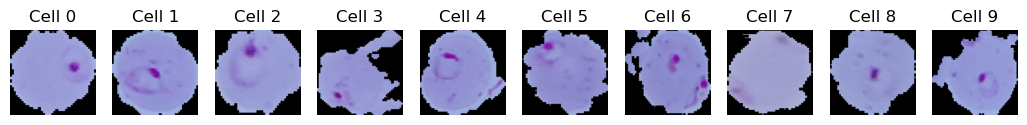

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(13,13))
for index, ax in enumerate(axes.flat):
    ax.set_title(f'Cell {index}')
    ax.imshow(dataset[index], cmap='cool')    
    ax.axis('off')
plt.show()

### Data preparation

#### Split the images into train, validation and test data

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = data_load(dataset, label)

In [12]:
print(f'X_train Shape : {X_train.shape}')
print(f'X_val Shape : {X_val.shape}')
print(f'X_test Shape : {X_test.shape}')
print(f'Y_train Shape : {y_train.shape}')
print(f'Y_val Shape : {y_val.shape}')
print(f'Y_test Shape : {y_test.shape}')

X_train Shape : (314, 150, 150, 3)
X_val Shape : (79, 150, 150, 3)
X_test Shape : (99, 150, 150, 3)
Y_train Shape : (314,)
Y_val Shape : (79,)
Y_test Shape : (99,)


##### Normalizing the data

In [13]:
X_train_norm, X_val_norm, X_test_norm, Y_train_norm, Y_val_norm, Y_test_norm = data_normalize(X_train, X_val, X_test, y_train, y_val, y_test)

In [14]:
print(f'X_train_norm Shape : {X_train_norm.shape}')
print(f'X_val_norm Shape : {X_val_norm.shape}')
print(f'X_test_norm Shape : {X_test_norm.shape}')
print(f'Y_train_norm Shape : {Y_train_norm.shape}')
print(f'Y_val_norm Shape : {Y_val_norm.shape}')
print(f'Y_test_norm Shape : {Y_test_norm.shape}')

X_train_norm Shape : (314, 150, 150, 3)
X_val_norm Shape : (79, 150, 150, 3)
X_test_norm Shape : (99, 150, 150, 3)
Y_train_norm Shape : (314,)
Y_val_norm Shape : (79,)
Y_test_norm Shape : (99,)


#### Q(a) Build a Convolutional Neural Network model that can predict the input image as uninfected or parasite. Note that the dataset could be highly imbalanced. (Hint: Use weighted sampling (or) weighted loss function (or) augment the dataset to generate more samples of the imbalanced class)

### ----------------------------------------------------------Start of Question (a) ----------------------------------------------------------

### Pytorch implementation of CNN model for given dataset

#### CNN model representation using pytorch

In [15]:
model_net = MalariaCellNet()
print(model_net)

MalariaCellNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


##### Trainer class implementation

In [28]:
class Trainer:
    
    def __init__(self, model, train_dl, val_dl, len_train_ds, len_val_ds, class_weight = None):
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.len_train_ds = len_train_ds
        self.len_val_ds = len_val_ds
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.class_weights = class_weight
        if(self.class_weights != None):
            self.criterion = nn.CrossEntropyLoss(weight=torch.Tensor(self.class_weights))# for handling imbalanced dataset
        else:
            self.criterion = nn.CrossEntropyLoss()

    def train(self, epochs):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        for epoch in range(epochs):
            running_loss = 0.0
            running_acc = 0.0
            for i, (inputs, labels) in enumerate(tqdm(self.train_dl)):
                inputs = inputs.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_acc += torch.sum(preds == labels.data)
            epoch_loss = running_loss / self.len_train_ds
            epoch_acc = running_acc.double() / self.len_train_ds
            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, epochs, epoch_loss, epoch_acc))            

    def test(self, data, len_data_dl):
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0.0
            true_labels = []
            pred_labels = []
            for inputs, labels in data:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                true_labels += labels.cpu().numpy().tolist()
                pred_labels += preds.cpu().numpy().tolist()
            acc = accuracy_score(true_labels, pred_labels)
            weighted_acc, report = get_classification_metrics(true_labels, pred_labels)
            return acc, weighted_acc, report   

#### Dataloader creation from the given dataset

In [29]:
malaria_dataset = MalariaDataset(workingDir) 
train_malaria_ds, validation_malaria_ds, test_malaria_ds = malaria_dataset.split_data()

In [30]:
len_train_ds = len(train_malaria_ds)
len_validation_ds = len(validation_malaria_ds)
len_test_ds = len(test_malaria_ds)

##### Verifying the dimension of the different dataset

In [31]:
print(f'Length of train_malaria_ds: {len_train_ds}')
print(f'Length of validation_malaria_ds: {len_validation_ds}')
print(f'Length of test_malaria_ds: {len_test_ds}')

Length of train_malaria_ds: 315
Length of validation_malaria_ds: 79
Length of test_malaria_ds: 98


#### Generating dataloader from prepared dataset

In [32]:
train_malaria_dl = DataLoader(train_malaria_ds, batch_size=64, shuffle=True)
validation_malaria_dl = DataLoader(validation_malaria_ds, batch_size=64, shuffle=True)
test_malaria_dl = DataLoader(test_malaria_ds, batch_size=64, shuffle=True)

In [33]:
positive_freq = positive_class / (positive_class + negative_class)
negative_freq = negative_class / (positive_class + negative_class)
positive_weight = (positive_class + negative_class) / (2 * positive_class)
negative_weight = (positive_class + negative_class) / (2 * negative_class)
class_weights = list([negative_weight,positive_weight])
class_weight_dict = {0: negative_weight, 1: positive_weight}
class_weights,class_weight_dict

([0.9800796812749004, 1.020746887966805],
 {0: 0.9800796812749004, 1: 1.020746887966805})

#### Train the CNN model using Pytorch 

In [34]:
trainer = Trainer(model_net, train_malaria_dl, validation_malaria_dl, len_train_ds, len_validation_ds, class_weights)

In [35]:
trainer.train(epochs)

100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Epoch [1/100], Loss: 0.2889, Accuracy: 0.9175


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch [2/100], Loss: 0.1943, Accuracy: 0.9302


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch [3/100], Loss: 0.1326, Accuracy: 0.9524


100%|██████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch [4/100], Loss: 0.1226, Accuracy: 0.9587


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch [5/100], Loss: 0.0682, Accuracy: 0.9778


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch [6/100], Loss: 0.0891, Accuracy: 0.9714


100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch [7/100], Loss: 0.0848, Accuracy: 0.9746


100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch [8/100], Loss: 0.0486, Accuracy: 0.9810


100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch [9/100], Loss: 0.0762, Accuracy: 0.9714


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch [10/100], Loss: 0.0481, Accuracy: 0.9873


100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch [11/100], Loss: 0.0590, Accuracy: 0.9841


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch [12/100], Loss: 0.0498, Accuracy: 0.9778


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Epoch [13/100], Loss: 0.0301, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch [14/100], Loss: 0.0351, Accuracy: 0.9905


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch [15/100], Loss: 0.0326, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch [16/100], Loss: 0.0263, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch [17/100], Loss: 0.0261, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch [18/100], Loss: 0.0317, Accuracy: 0.9841


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch [19/100], Loss: 0.0238, Accuracy: 0.9968


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Epoch [20/100], Loss: 0.0240, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch [21/100], Loss: 0.0162, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch [22/100], Loss: 0.0160, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch [23/100], Loss: 0.0170, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch [24/100], Loss: 0.0192, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch [25/100], Loss: 0.0185, Accuracy: 0.9905


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch [26/100], Loss: 0.0206, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Epoch [27/100], Loss: 0.0209, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch [28/100], Loss: 0.0192, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch [29/100], Loss: 0.0228, Accuracy: 0.9905


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch [30/100], Loss: 0.0186, Accuracy: 0.9937


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch [31/100], Loss: 0.0160, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Epoch [32/100], Loss: 0.0101, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch [33/100], Loss: 0.0103, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch [34/100], Loss: 0.0111, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch [35/100], Loss: 0.0067, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch [36/100], Loss: 0.0087, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch [37/100], Loss: 0.0067, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch [38/100], Loss: 0.0076, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch [39/100], Loss: 0.0051, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch [40/100], Loss: 0.0050, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch [41/100], Loss: 0.0048, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch [42/100], Loss: 0.0035, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch [43/100], Loss: 0.0034, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch [44/100], Loss: 0.0045, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch [45/100], Loss: 0.0033, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Epoch [46/100], Loss: 0.0044, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Epoch [47/100], Loss: 0.0035, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Epoch [48/100], Loss: 0.0067, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch [49/100], Loss: 0.0030, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Epoch [50/100], Loss: 0.0099, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


Epoch [51/100], Loss: 0.0104, Accuracy: 0.9968


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch [52/100], Loss: 0.0095, Accuracy: 0.9937


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch [53/100], Loss: 0.0045, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch [54/100], Loss: 0.0027, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch [55/100], Loss: 0.0038, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch [56/100], Loss: 0.0030, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch [57/100], Loss: 0.0032, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch [58/100], Loss: 0.0019, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Epoch [59/100], Loss: 0.0017, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Epoch [60/100], Loss: 0.0018, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


Epoch [61/100], Loss: 0.0021, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch [62/100], Loss: 0.0031, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch [63/100], Loss: 0.0017, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch [64/100], Loss: 0.0017, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch [65/100], Loss: 0.0014, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch [66/100], Loss: 0.0022, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Epoch [67/100], Loss: 0.0080, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch [68/100], Loss: 0.0052, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch [69/100], Loss: 0.0023, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch [70/100], Loss: 0.0039, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch [71/100], Loss: 0.0048, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch [72/100], Loss: 0.0040, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch [73/100], Loss: 0.0016, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Epoch [74/100], Loss: 0.0015, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Epoch [75/100], Loss: 0.0016, Accuracy: 1.0000


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch [76/100], Loss: 0.0014, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch [77/100], Loss: 0.0012, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch [78/100], Loss: 0.0014, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch [79/100], Loss: 0.0010, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Epoch [80/100], Loss: 0.0017, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


Epoch [81/100], Loss: 0.0019, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch [82/100], Loss: 0.0014, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch [83/100], Loss: 0.0014, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch [84/100], Loss: 0.0009, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch [85/100], Loss: 0.0015, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch [86/100], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch [87/100], Loss: 0.0008, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Epoch [88/100], Loss: 0.0008, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch [89/100], Loss: 0.0006, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch [90/100], Loss: 0.0006, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch [91/100], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch [92/100], Loss: 0.0007, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch [93/100], Loss: 0.0008, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch [94/100], Loss: 0.0009, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch [95/100], Loss: 0.0007, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch [96/100], Loss: 0.0008, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch [97/100], Loss: 0.0007, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch [98/100], Loss: 0.0008, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch [99/100], Loss: 0.0006, Accuracy: 1.0000


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

Epoch [100/100], Loss: 0.0009, Accuracy: 1.0000


### ----------------------------------------------------------End of Question (a) ----------------------------------------------------------

#### Q(b). Report the prediction accuracy, precision, recall, and F1 score in the test dataset.

### ----------------------------------------------------------Start of Question (b) ----------------------------------------------------------

### Performance metrices representation for Train, Validation and Test set

### Using Pytorch with class weighting

In [24]:
#Train
train_accuracy, train_weighted_acc, train_report = trainer.test(train_malaria_dl, len_train_ds)
#Validation
val_accuracy, val_weighted_acc, val_report = trainer.test(validation_malaria_dl, len_validation_ds)
#Test
test_accuracy, test_weighted_acc, test_report = trainer.test(test_malaria_dl, len_test_ds)

In [25]:
summerize_metrics_torch(train_accuracy ,train_weighted_acc, train_report, instance = 'Train')

Train Accuracy 1.0
Train Weighted Accuracy 1.0


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,1.0,1.0,1.0,1.0,159.0
1,1.0,1.0,1.0,1.0,156.0


In [26]:
summerize_metrics_torch(val_accuracy ,val_weighted_acc, val_report, instance = 'Validation')

Validation Accuracy 0.8860759493670886
Validation Weighted Accuracy 0.8858904355246641


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,0.89,0.91,0.90,0.91,44.0
1,0.88,0.86,0.87,0.86,35.0


In [27]:
summerize_metrics_torch(test_accuracy ,test_weighted_acc, test_report, instance = 'Test')

Test Accuracy 0.8571428571428571
Test Weighted Accuracy 0.8571428571428571


,Precision,Recall,F1 - Score,Accuracy - Category wise,Count - Category wise
0,0.84,0.88,0.86,0.88,48.0
1,0.88,0.84,0.86,0.84,50.0


#### We have displayed the performance metrics  (like accuracy, precision, recall etc) for train, validation and test set. 
### Conclusion : 
1. We have created CNN using Pytorch considering the effect of imbalance dataset.
2. Given dataset is highly imbalance, and we have calculated class weighting to handle the effect of imbalance dataset along with that we have done data augmentation during the transformation of the dataset.
3. Model created using Pytorch is coded to handled the effect of imbalance dataset using class weighting and different data augmentation.
4. Looking at the performance metrics it is evident that accuracy for two label is in a balanced state.
5. We have achieved good accuracy in test set indicating that the model is good in prediction on unseen dataset.